In [17]:
import nflreadpy as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pathlib import Path




In [3]:
schedule = nfl.load_schedules([2021, 2022, 2023, 2024, 2025]).to_pandas() #Import schedules and game info for 2021-2025 seasons
games = schedule[
    (schedule['game_type']=='REG') & #include only regular season games
    (schedule['home_score'].notna())&
    (schedule['away_score'].notna())
].copy()

In [4]:
games['home_win'] = (games['home_score'] > games['away_score']).astype(int) #Home win variable
games

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium,home_win
0,2021_01_DAL_TB,2021,REG,1,2021-09-09,Thursday,20:20,DAL,29.0,TB,...,00-0033077,00-0019596,Dak Prescott,Tom Brady,Mike McCarthy,Bruce Arians,Shawn Hochuli,TAM00,Raymond James Stadium,1
1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,Sunday,13:00,PHI,32.0,ATL,...,00-0036389,00-0026143,Jalen Hurts,Matt Ryan,Nick Sirianni,Arthur Smith,Scott Novak,ATL97,Mercedes-Benz Stadium,0
2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,Sunday,13:00,PIT,23.0,BUF,...,00-0022924,00-0034857,Ben Roethlisberger,Josh Allen,Mike Tomlin,Sean McDermott,John Hussey,BUF00,New Era Field,0
3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,Sunday,13:00,NYJ,14.0,CAR,...,00-0037013,00-0034869,Zach Wilson,Sam Darnold,Robert Saleh,Matt Rhule,Clay Martin,CAR00,Bank of America Stadium,1
4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,Sunday,13:00,MIN,24.0,CIN,...,00-0029604,00-0036442,Kirk Cousins,Joe Burrow,Mike Zimmer,Zac Taylor,Adrian Hill,CIN00,Paul Brown Stadium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,2025_17_NE_NYJ,2025,REG,17,2025-12-28,Sunday,13:00,NE,42.0,NYJ,...,00-0039851,00-0028118,Drake Maye,Tyrod Taylor,Mike Vrabel,Aaron Glenn,Alex Kemp,NYC01,MetLife Stadium,0
1391,2025_17_NO_TEN,2025,REG,17,2025-12-28,Sunday,13:00,NO,34.0,TEN,...,00-0040743,00-0040676,Tyler Shough,Cam Ward,Kellen Moore,Brian Callahan,Adrian Hill,NAS00,Nissan Stadium,0
1392,2025_17_PHI_BUF,2025,REG,17,2025-12-28,Sunday,16:25,PHI,13.0,BUF,...,00-0036389,00-0034857,Jalen Hurts,Josh Allen,Nick Sirianni,Sean McDermott,Ron Torbert,BUF00,New Era Field,0
1393,2025_17_CHI_SF,2025,REG,17,2025-12-28,Sunday,20:20,CHI,38.0,SF,...,00-0039918,00-0037834,Caleb Williams,Brock Purdy,Ben Johnson,Kyle Shanahan,Alex Moore,SFO01,Levi's Stadium,1


In [5]:
# Load all available team level stats
team_stats = nfl.load_team_stats([2021, 2022, 2023, 2024, 2025]).to_pandas() #load team and game stats for 2021-2025 seasons
team_stats['turnovers_offense'] = (team_stats['passing_interceptions']+ #rows correspond to single game stats
                                 team_stats['sack_fumbles_lost']+
                                 team_stats['rushing_fumbles_lost']+
                                 team_stats['receiving_fumbles_lost']
                                 )
team_stats['turnovers_defense'] = (team_stats['def_interceptions']+
                                 team_stats['def_fumbles'])
team_stats['turnover_margin'] = (team_stats['turnovers_defense']-
                               team_stats['turnovers_offense'])
team_stats['completion_pct'] = (team_stats['completions']/team_stats['attempts'])


In [6]:
independent_variables = ['completions',
                       'passing_yards',
                       'passing_tds',
                       'rushing_yards',
                       'sacks_suffered',
                       'rushing_tds',
                       'completion_pct',
                       'turnovers_offense',
                       'turnovers_defense',
                       'turnover_margin',
                       'def_tackles_for_loss',
                       'penalty_yards',
                       'fg_pct',
                       'pat_pct',
                       ]


In [7]:
for var in independent_variables: #make an exponential weighted mean to favor more recent game stats
    team_stats[f'{var}_ewma'] = team_stats.groupby('team')[var].transform(
        lambda x: x.ewm(alpha=0.4, adjust=False).mean()
    )

#ewma_cols = [f'{col}_ewma' for col in ]

In [42]:
ewma_cols = [f'{col}_ewma' for col in independent_variables]
keep_cols = ['season', 'week', 'team', 'opponent_team'] + ewma_cols
df_filtered=team_stats[keep_cols]

df_filtered.to_csv('../data/df_clean.csv')

In [9]:
home_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
home_stats.columns = ['season', 'week', 'home_team'] + [f'home_{col}' for col in ewma_cols]

# For away team stats
away_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
away_stats.columns = ['season', 'week', 'away_team'] + [f'away_{col}' for col in ewma_cols]


In [ ]:
games_with_stats=games.merge(
    home_stats,
    on=['season', 'week', 'home_team'],
    how='left'
).merge(
    away_stats,
    on=['season', 'week', 'away_team'],
    how='left'
)

csv = pd.read_csv('../data/games_with_stats.csv')

,Unnamed: 0,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,...,away_sacks_suffered_ewma,away_rushing_tds_ewma,away_completion_pct_ewma,away_turnovers_offense_ewma,away_turnovers_defense_ewma,away_turnover_margin_ewma,away_def_tackles_for_loss_ewma,away_penalty_yards_ewma,away_fg_pct_ewma,away_pat_pct_ewma
0,0,2021_01_DAL_TB,2021,REG,1,2021-09-09,Thursday,20:20,DAL,29.0,...,1.000000,0.000000,0.724138,1.000000,2.000000,1.000000,0.000000,55.000000,0.600000,0.666667
1,1,2021_01_PHI_ATL,2021,REG,1,2021-09-12,Sunday,13:00,PHI,32.0,...,1.000000,1.000000,0.771429,0.000000,0.000000,0.000000,6.000000,89.000000,1.000000,1.000000
2,2,2021_01_PIT_BUF,2021,REG,1,2021-09-12,Sunday,13:00,PIT,23.0,...,2.000000,0.000000,0.562500,0.000000,0.000000,0.000000,5.000000,32.000000,1.000000,1.000000
3,3,2021_01_NYJ_CAR,2021,REG,1,2021-09-12,Sunday,13:00,NYJ,14.0,...,6.000000,0.000000,0.540541,1.000000,0.000000,-1.000000,4.000000,30.000000,NaN,NaN
4,4,2021_01_MIN_CIN,2021,REG,1,2021-09-12,Sunday,13:00,MIN,24.0,...,3.000000,1.000000,0.740000,1.000000,0.000000,-1.000000,7.000000,116.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1325,2025_16_CIN_MIA,2025,REG,16,2025-12-21,Sunday,13:00,CIN,45.0,...,1.935194,0.978606,0.689377,1.038185,1.199554,0.161369,3.665755,25.632860,0.985377,0.999981
1326,1326,2025_16_SF_IND,2025,REG,16,2025-12-22,Monday,20:15,SF,48.0,...,1.174111,0.804491,0.713765,1.014862,0.699205,-0.315657,2.736576,27.593737,0.865868,0.963514
1327,1327,2025_17_DAL_WAS,2025,REG,17,2025-12-25,Thursday,13:00,DAL,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1328,1328,2025_17_DET_MIN,2025,REG,17,2025-12-25,Thursday,16:30,DET,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Replace missing values with 0 in columns: 'home_completions_ewma', 'home_passing_yards_ewma' and 24 other columns
# csv = csv.fillna({'home_completions_ewma': 0, 'home_passing_yards_ewma': 0, 'home_passing_tds_ewma': 0, 'home_rushing_yards_ewma': 0, 'home_sacks_suffered_ewma': 0, 'home_rushing_tds_ewma': 0, 'home_completion_pct_ewma': 0, 'home_turnovers_offense_ewma': 0, 'home_turnovers_defense_ewma': 0, 'home_penalty_yards_ewma': 0, 'home_turnover_margin_ewma': 0, 'home_fg_pct_ewma': 0, 'home_pat_pct_ewma': 0, 'away_completions_ewma': 0, 'away_passing_yards_ewma': 0, 'away_passing_tds_ewma': 0, 'away_rushing_yards_ewma': 0, 'away_sacks_suffered_ewma': 0, 'away_rushing_tds_ewma': 0, 'away_turnovers_offense_ewma': 0, 'away_turnovers_defense_ewma': 0, 'away_turnover_margin_ewma': 0, 'away_def_tackles_for_loss_ewma': 0, 'away_penalty_yards_ewma': 0, 'away_fg_pct_ewma': 0, 'away_pat_pct_ewma': 0})

# # Replace missing values with 0 in column: 'home_def_tackles_for_loss_ewma'
# csv = csv.fillna({'home_def_tackles_for_loss_ewma': 0})

# # Replace missing values with 0 in column: 'away_completion_pct_ewma'
# csv = csv.fillna({'away_completion_pct_ewma': 0})

# # Round columns 'home_completions_ewma', 'home_passing_yards_ewma' and 26 other columns (Number of decimals: 2)
# csv = csv.round({'home_completions_ewma': 2, 'home_passing_yards_ewma': 2, 'home_passing_tds_ewma': 2, 'home_rushing_yards_ewma': 2, 'home_sacks_suffered_ewma': 2, 'home_rushing_tds_ewma': 2, 'home_completion_pct_ewma': 2, 'home_turnovers_offense_ewma': 2, 'home_turnovers_defense_ewma': 2, 'home_turnover_margin_ewma': 2, 'home_def_tackles_for_loss_ewma': 2, 'home_penalty_yards_ewma': 2, 'home_fg_pct_ewma': 2, 'home_pat_pct_ewma': 2, 'away_completions_ewma': 2, 'away_passing_yards_ewma': 2, 'away_passing_tds_ewma': 2, 'away_rushing_yards_ewma': 2, 'away_sacks_suffered_ewma': 2, 'away_rushing_tds_ewma': 2, 'away_completion_pct_ewma': 2, 'away_turnovers_offense_ewma': 2, 'away_turnovers_defense_ewma': 2, 'away_turnover_margin_ewma': 2, 'away_def_tackles_for_loss_ewma': 2, 'away_penalty_yards_ewma': 2, 'away_fg_pct_ewma': 2, 'away_pat_pct_ewma': 2})

# # Drop columns: 'nfl_detail_id', 'pff' and 5 other columns
# csv = csv.drop(columns=['nfl_detail_id', 'pff', 'ftn', 'surface', 'temp', 'wind', 'referee'])
# csv

In [28]:
feature_columns = []
for col in ewma_cols:
    diff_col = f'diff_{col}'
    csv[diff_col] = csv[f'home_{col}'] - csv[f'away_{col}']
    feature_columns.append(diff_col)
csv[feature_columns]


,diff_completions_ewma,diff_passing_yards_ewma,diff_passing_tds_ewma,diff_rushing_yards_ewma,diff_sacks_suffered_ewma,diff_rushing_tds_ewma,diff_completion_pct_ewma,diff_turnovers_offense_ewma,diff_turnovers_defense_ewma,diff_turnover_margin_ewma,diff_def_tackles_for_loss_ewma,diff_penalty_yards_ewma,diff_fg_pct_ewma,diff_pat_pct_ewma
0,-10.00,-24.00,1.00,-8.00,-1.00,0.00,-0.08,3.00,-1.00,-4.00,2.00,51.00,0.40,0.33
1,-6.00,-100.00,-3.00,-49.00,2.00,-1.00,-0.17,0.00,0.00,0.00,-1.00,10.00,0.00,-1.00
2,12.00,82.00,0.00,42.00,1.00,0.00,0.03,1.00,0.00,-1.00,-1.00,49.00,0.00,0.00
3,4.00,21.00,-1.00,66.00,-5.00,1.00,0.15,0.00,1.00,1.00,2.00,8.00,1.00,0.50
4,-17.00,-101.00,0.00,82.00,2.00,0.00,0.00,-1.00,0.00,1.00,0.00,-101.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,-6.67,-53.57,-1.82,35.11,-0.24,0.86,-0.01,0.64,-0.60,-1.24,0.44,4.64,0.00,-0.01
1326,-1.98,-43.33,-1.84,-42.81,0.46,0.07,-0.07,0.23,-0.11,-0.32,1.25,11.33,0.12,-0.02
1327,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1328,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [29]:
train_data = csv[csv['season']< 2025]
test_data=csv[csv['season'] == 2025]



In [30]:
X_train = train_data[feature_columns]
y_train = train_data['home_win']

In [31]:
X_test = test_data[feature_columns]
y_test = test_data['home_win']

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [33]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=67, max_depth=20, min_samples_split=20)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

In [34]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)
top_features = feature_importance.head(10)
feature_list = top_features['feature'].to_list()



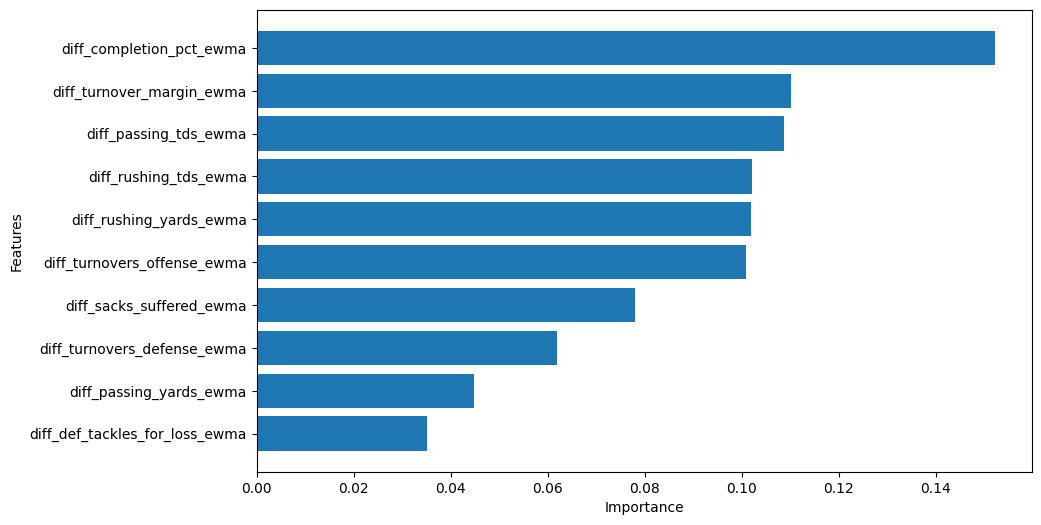

In [41]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
X_train_selected = train_data[feature_list]
X_test_selected = test_data[feature_list]
X_train_selected


,diff_completion_pct_ewma,diff_turnover_margin_ewma,diff_passing_tds_ewma,diff_rushing_tds_ewma,diff_rushing_yards_ewma,diff_turnovers_offense_ewma,diff_sacks_suffered_ewma,diff_turnovers_defense_ewma,diff_passing_yards_ewma,diff_def_tackles_for_loss_ewma
0,-0.08,-4.00,1.00,0.00,-8.00,3.00,-1.00,-1.00,-24.00,2.00
1,-0.17,0.00,-3.00,-1.00,-49.00,0.00,2.00,0.00,-100.00,-1.00
2,0.03,-1.00,0.00,0.00,42.00,1.00,1.00,0.00,82.00,-1.00
3,0.15,1.00,-1.00,1.00,66.00,0.00,-5.00,1.00,21.00,2.00
4,0.00,1.00,0.00,0.00,82.00,-1.00,2.00,0.00,-101.00,0.00
...,...,...,...,...,...,...,...,...,...,...
1082,0.13,-1.19,1.87,0.05,58.11,0.59,-1.65,-0.60,64.88,0.23
1083,-0.08,-0.04,-0.95,0.34,-13.01,-0.17,-1.32,-0.21,24.89,-0.90
1084,-0.08,-0.91,-0.59,-0.71,-41.55,0.52,-0.14,-0.39,-53.86,-0.05
1085,-0.05,1.85,1.51,-0.70,-0.84,-0.64,-0.34,1.21,16.78,2.25


In [38]:
scaler_selected = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)


In [39]:
model = LogisticRegression(random_state=67, max_iter=1000)
model.fit(X_train_scaled, y_train)
lr_all_train = model.score(X_train_scaled, y_train)
lr_all_test = model.score(X_test_scaled, y_test)


In [40]:

#Logistic Regression - Selected Features
model_selected = LogisticRegression(random_state=41, max_iter=1000)
model_selected.fit(X_train_scaled_selected, y_train)
lr_sel_train = model_selected.score(X_train_scaled_selected, y_train)
lr_sel_test = model_selected.score(X_test_scaled_selected, y_test)

print("All variables train:", lr_all_train,
      "All variables test:", lr_all_test)
print("Selected variables train:", lr_sel_train,
      "Selected variables test:", lr_sel_test)


All variables train: 0.8307267709291628 All variables test: 0.8189300411522634
Selected variables train: 0.8077276908923643 Selected variables test: 0.8148148148148148


In [ ]:
model_selected.predict()